In [1]:
import pandas as pd 
from xgboost.sklearn import XGBClassifier  
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import numpy as np # linear algebra
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Reading Data

In [2]:
trainData = pd.read_csv('all/train.csv',index_col=0)
testData = pd.read_csv('all/test.csv',index_col=0)
submissionData = pd.read_csv('all/sample_submission.csv',index_col=0);
trainData['MSSubClass'].head()

Id
1    60
2    20
3    60
4    70
5    60
Name: MSSubClass, dtype: int64

In [3]:
trainData.shape

(1460, 80)

In [4]:
testData.shape

(1459, 79)

# Preparing Data

In [5]:
trainData.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,6,1965,1965,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,CBlock,TA,TA,No,BLQ,830,LwQ,290,136,1256,GasA,Gd,Y,SBrkr,1256,0,0,1256,1,0,1,1,3,1,TA,6,Typ,0,NaN,Attchd,1965.0,Fin,1,276,TA,TA,Y,736,68,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [6]:
allDataNa = (trainData.isnull().sum() / len(trainData)) * 100
allDataNa = allDataNa.drop(allDataNa[allDataNa == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :allDataNa})
missing_data.head(20)

,Missing Ratio
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
LotFrontage,17.739726
GarageYrBlt,5.547945
GarageType,5.547945
GarageFinish,5.547945
GarageQual,5.547945


## Remove the columns which have more 5% of null values and discrimination of others

In [7]:
columns = ['PoolQC','MiscFeature','Alley','Fence','MSSubClass','OverallCond','BsmtFinSF2','LowQualFinSF','BsmtHalfBath','KitchenAbvGr',
          'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold','LotFrontage','GarageYrBlt',
          'GarageType','GarageFinish','GarageQual','GarageCond','BsmtFinType2','BsmtExposure','BsmtFinType1','BsmtCond','BsmtQual',
          'Street','LotShape','LotConfig','LandSlope','Condition1','Condition2','RoofStyle','RoofMatl','MasVnrType',
          'Heating','SaleType','SaleCondition'] 
trainData.drop(columns,inplace=True,axis=1)
testData.drop(columns,inplace=True,axis=1)

In [8]:
trainData.shape

(1460, 40)

In [9]:
testData.shape

(1459, 39)

In [10]:
trainData.columns

Index(['MSZoning', 'LotArea', 'LandContour', 'Utilities', 'Neighborhood',
       'BldgType', 'HouseStyle', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
       'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageCars',
       'GarageArea', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice'],
      dtype='object')

## Correlation Data 

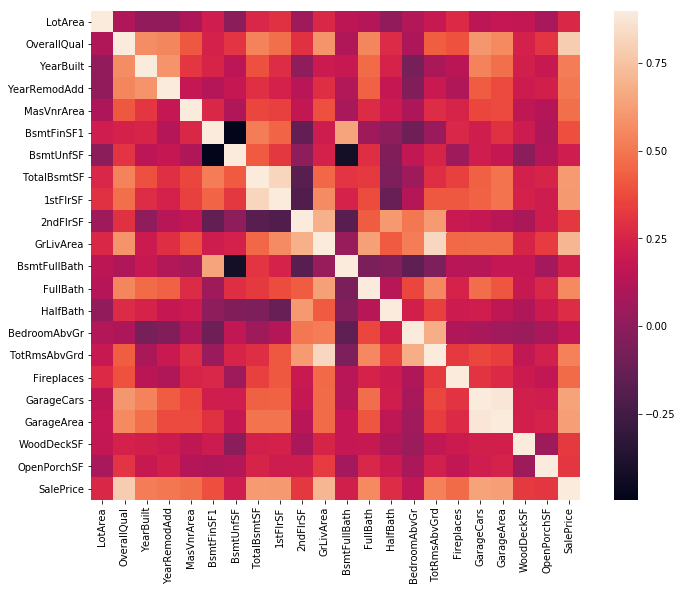

In [11]:
corrmat = trainData.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [12]:
trainData.head()

,MSZoning,LotArea,LandContour,Utilities,Neighborhood,BldgType,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,RL,8450,Lvl,AllPub,CollgCr,1Fam,2Story,7,2003,2003,VinylSd,VinylSd,196.0,Gd,TA,PConc,706,150,856,Ex,Y,SBrkr,856,854,1710,1,2,1,3,Gd,8,Typ,0,NaN,2,548,Y,0,61,208500
2,RL,9600,Lvl,AllPub,Veenker,1Fam,1Story,6,1976,1976,MetalSd,MetalSd,0.0,TA,TA,CBlock,978,284,1262,Ex,Y,SBrkr,1262,0,1262,0,2,0,3,TA,6,Typ,1,TA,2,460,Y,298,0,181500
3,RL,11250,Lvl,AllPub,CollgCr,1Fam,2Story,7,2001,2002,VinylSd,VinylSd,162.0,Gd,TA,PConc,486,434,920,Ex,Y,SBrkr,920,866,1786,1,2,1,3,Gd,6,Typ,1,TA,2,608,Y,0,42,223500
4,RL,9550,Lvl,AllPub,Crawfor,1Fam,2Story,7,1915,1970,Wd Sdng,Wd Shng,0.0,TA,TA,BrkTil,216,540,756,Gd,Y,SBrkr,961,756,1717,1,1,0,3,Gd,7,Typ,1,Gd,3,642,Y,0,35,140000
5,RL,14260,Lvl,AllPub,NoRidge,1Fam,2Story,8,2000,2000,VinylSd,VinylSd,350.0,Gd,TA,PConc,655,490,1145,Ex,Y,SBrkr,1145,1053,2198,1,2,1,4,Gd,9,Typ,1,TA,3,836,Y,192,84,250000


## Convert Categorical Data

In [13]:
categoricalColumns = ['BldgType','CentralAir',
                      'Electrical','ExterCond','ExterQual','Exterior1st','Exterior2nd', 
                      'FireplaceQu','Foundation','Functional','PavedDrive',
                      'HeatingQC','HouseStyle', 'KitchenQual','LandContour',
                      'MSZoning','Neighborhood','Utilities']
trainData = trainData.fillna("none")
testData = testData.fillna("none")
le = preprocessing.LabelEncoder()
trainData.dtypes
for column in categoricalColumns:
    print(column)
    le.fit(trainData[column])
    trainData[column] = le.fit_transform(trainData[column])
    le.fit(testData[column])
    testData[column] = le.fit_transform(testData[column])
trainData.replace('none', 0,inplace=True)
testData.replace('none', 0,inplace=True)
trainData.head()
testData.head()

BldgType
CentralAir
Electrical
ExterCond
ExterQual
Exterior1st
Exterior2nd
FireplaceQu
Foundation
Functional
PavedDrive
HeatingQC
HouseStyle
KitchenQual
LandContour
MSZoning
Neighborhood
Utilities


,MSZoning,LotArea,LandContour,Utilities,Neighborhood,BldgType,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,2,11622,3,0,12,0,2,5,1961,1961,10,12,0.0,3,4,1,468.0,270.0,882.0,4,1,3,896,0,896,0.0,1,0,2,3,5,6,0,5,1.0,730.0,2,140,0
1462,3,14267,3,0,12,0,2,6,1958,1958,11,13,108.0,3,4,1,923.0,406.0,1329.0,4,1,3,1329,0,1329,0.0,1,1,3,2,6,6,0,5,1.0,312.0,2,393,36
1463,3,13830,3,0,8,0,4,5,1997,1998,10,12,0.0,3,4,2,791.0,137.0,928.0,2,1,3,928,701,1629,0.0,2,1,3,3,6,6,1,4,2.0,482.0,2,212,34
1464,3,9978,3,0,8,0,4,6,1998,1998,10,12,20.0,3,4,2,602.0,324.0,926.0,0,1,3,926,678,1604,0.0,2,1,3,2,7,6,1,2,2.0,470.0,2,360,36
1465,3,5005,1,0,22,4,2,8,1992,1992,6,6,0.0,2,4,2,263.0,1017.0,1280.0,0,1,3,1280,0,1280,0.0,2,0,2,2,5,6,0,5,2.0,506.0,2,0,82


In [14]:
trainData.shape

(1460, 40)

In [15]:
trainData.insert(0, "bias", 1)

# Models 

## Define of Random Forest and My Linear Regression Models 

In [16]:
xgregr = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=200)
features = trainData.columns[:39]

In [17]:
#Define Random Forest 
def RandomForest(pTrain,pYTrain,pTest,pYTest):
    regr.fit(pTrain, pYTrain)
    predict = regr.predict(pTest)
    MSE = mean_squared_error(pYTest,predict)
    errorRF=np.sqrt(np.mean((np.log(1+predict) - np.log(1+pYTest))**2))
    print("Logarithmic Regression of Random Forest model: ", errorRF)
    print("RMSE ", np.sqrt(MSE))
    
#Define XGBOOST
def xgboost(pTrain,pYTrain,pTest,pYTest):
    xgregr.fit(pTrain, pYTrain)  
    predict = xgregr.predict(pTest)
    MSE = mean_squared_error(pYTest,predict)
    errorXGB=np.sqrt(np.mean((np.log(1+predict) - np.log(1+pYTest))**2))
    print("Logarithmic Regression of XGBOOST model: ", errorXGB)
    print("RMSE ", np.sqrt(MSE))
    
#Define My Linear Regression 
def MyLinearRegression(pTrain,pYTrain,pTest,pYTest,cross):
    alfa = np.power(10.0,-14.0)
    parameters = 10 * np.random.random_sample((len(features)+1,1)) 
    print(pTrain.shape)
    sum = 0
    count = 0
    cycle = 1000000
    while(count < cycle):
        h = np.matmul(pTrain,parameters)
        error1 = pYTrain - h
        derivate = np.matmul(error1.T,pTrain)
        parameters = parameters + (alfa * derivate.T)
        powError = error1[0] ** 2
        cycleError = powError.sum()
        cost = 1.0/pTrain.shape[0] * cycleError
        count= count + 1
        alfa = alfa + np.power(10.0,-19.0)
        if(count % 100000 == 0):    
            hTest = np.matmul(pTest,parameters)
            MSE = mean_squared_error(pYTest,hTest)
            err_ep=np.sqrt(np.mean((np.log(1+hTest) - np.log(1+pYTest))**2))
            print("iteracion ", count)
            print("Logarithmic Regression of My Linear Regression ", err_ep)
            print("RMSE ",np.sqrt(MSE))
    if(cross == 1):
        global mrlWeight
        mrlWeight = parameters
        print("Get the best parameters")

## Cross Validation 

In [ ]:
### Cross validation 
kFolds = KFold(n_splits=5)
npTrainData = trainData.values
countCross = 1 
for train, test in kFolds.split(npTrainData):
    trainD = npTrainData[train,0:40]
    testD = npTrainData[test,0:40]
    yTrain = npTrainData[train,40:41]
    yTest = npTrainData[test,40:41]
    print("------------- CROSS VALIDATION ",countCross,"---------")
    print("------------- Random Forest ---------")
    RandomForest(trainD,yTrain.ravel(),testD,yTest.ravel())
    print("------------- XGBOOST ---------")
    xgboost(trainD,yTrain.ravel(),testD,yTest.ravel())
    print("------------- My Linear Regression ---------")
    MyLinearRegression(trainD,yTrain,testD,yTest,countCross)
    countCross = countCross + 1

------------- CROSS VALIDATION  1 ---------
------------- Random Forest ---------
Logarithmic Regression of Random Forest model:  0.2438991304122254
RMSE  43562.52708446623
------------- XGBOOST ---------
Logarithmic Regression of XGBOOST model:  0.12570034701917968
RMSE  24074.31407853383
------------- My Linear Regression ---------
(1168, 40)
iteracion  100000
Logarithmic Regression of My Linear Regression  0.23839968453715207
RMSE  45422.48895863451
iteracion  200000
Logarithmic Regression of My Linear Regression  0.2096386073166769
RMSE  40616.06264623083
iteracion  300000
Logarithmic Regression of My Linear Regression  0.20078611087202447
RMSE  38806.58347449832
iteracion  400000
Logarithmic Regression of My Linear Regression  0.19729023718285277
RMSE  37934.63759697395
iteracion  500000
Logarithmic Regression of My Linear Regression  0.19480092704535226
RMSE  37324.28632156594
iteracion  600000
Logarithmic Regression of My Linear Regression  0.19301829308225846
RMSE  36858.192325

## Best Results of the models 

### Minimal Error of each Model 
Random forest = 0.23831681364231874

RMSE = 49878.893535341325

XGBOOST = 0.11932953018380113

RMSE = 22691.587757873243

My Linear Regression = 0.19116013867391393

RMSE = 36033.84013048413

In [57]:
testData.insert(0, "bias", 1) 
sampleSubmission = pd.DataFrame(columns=['Id','SalePrice'])
sampleSubmission.shape

(0, 2)

In [58]:
global mrlWeight
mrlWeight

NameError: name 'mrlWeight' is not defined

In [135]:
testData.shape
npTestData = testData.values
npTestData

array([[1.0000e+00, 2.0000e+00, 1.1622e+04, ..., 2.0000e+00, 1.4000e+02,
        0.0000e+00],
       [1.0000e+00, 3.0000e+00, 1.4267e+04, ..., 2.0000e+00, 3.9300e+02,
        3.6000e+01],
       [1.0000e+00, 3.0000e+00, 1.3830e+04, ..., 2.0000e+00, 2.1200e+02,
        3.4000e+01],
       ...,
       [1.0000e+00, 3.0000e+00, 2.0000e+04, ..., 2.0000e+00, 4.7400e+02,
        0.0000e+00],
       [1.0000e+00, 3.0000e+00, 1.0441e+04, ..., 2.0000e+00, 8.0000e+01,
        3.2000e+01],
       [1.0000e+00, 3.0000e+00, 9.6270e+03, ..., 2.0000e+00, 1.9000e+02,
        4.8000e+01]])

## Get Predicts of My Linear Regression 

In [136]:
PredictTest = np.matmul(npTestData,mrlWeight)

In [137]:
np.savetxt("PredictTest.csv", PredictTest, delimiter=",")